In [1]:
# Works based on https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# Preprocessing based on https://github.com/TegarSU/Topic-Modelling/blob/master/Preprocessing.ipynb
import pandas as pd
import numpy as np
import json
import os
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt

import spacy
from spacy.lang.id import Indonesian

nlp = Indonesian()  # use directly
stopwords = spacy.lang.id.stop_words.STOP_WORDS
stopwords.add("nya")

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [2]:
df = pd.read_csv(os.path.join(os.pardir,'tweet_removed.csv'))

In [3]:
df.head()

,text,username,modularity
0,Mereka itu korban yg kalah di 2014. Inget siap...,b12_7hon,3
1,Penomena @KPU_RI @KPU_ID tdk kuat scra lembaga...,harun_nugraha,15
2,ngapain pemilu ulang broo klu kita 02 sdh mena...,totonaser11,19
3,"Kl menerapkan ISO pasti kelar 1 minggu, ngga a...",rohmatjabbar,19
4,Hayooo @KPU_ID @bawaslu_RI simak baik2 orasi k...,use_will,14


## Preprocessing

### Cleaning

In [4]:
df['clean'] = df['text'].str.lower()
df['clean'] = df['clean'].str.normalize('NFKD')
df['clean'] = df['clean'].str.replace(r"http\S+|https\S+|pic\.\S+|pictw\S+|CC|cc|Cc|cC|www\S+|t\.co\S+", " ") # remove http, https, pic, CC
df['clean'] = df['clean'].str.replace(r"RT @[\w_]+ :", " ") # remove RT @ :
df['clean'] = df['clean'].str.replace("[@#][A-Za-z0-9_]+", " ") # remove mention and hashtag
# df['clean'] = df['clean'].str.replace(r"[():/.,!?\"\\-]"," ") # remove punctuation
df['clean'] = df['clean'].str.replace(r"[^a-zA-Z]"," ") # remove non alphabet r'[^a-zA-Z]'
# Tambahin remove 'CC'
df['clean'] = df['clean'].str.lstrip()
df['clean'] = df['clean'].str.replace(r"\s\s+"," ") # remove multi space after regex

In [5]:
df['clean'].head()

0    mereka itu korban yg kalah di inget siapa yg l...
1    penomena tdk kuat scra lembaga atw pelaksanaan...
2    ngapain pemilu ulang broo klu kita sdh menang ...
3    kl menerapkan iso pasti kelar minggu ngga ada ...
4    hayooo simak baik orasi ketua satgas anti cura...
Name: clean, dtype: object

### Tokenize

In [6]:
def df_tokenizer(tweets_df):
    tokenized = [token.text for token in nlp(tweets_df)]
    return tokenized

In [7]:
tokenized = df['clean'].apply(df_tokenizer)

In [8]:
tokenized.head()

0    [mereka, itu, korban, yg, kalah, di, inget, si...
1    [penomena, tdk, kuat, scra, lembaga, atw, pela...
2    [ngapain, pemilu, ulang, broo, klu, kita, sdh,...
3    [kl, menerapkan, iso, pasti, kelar, minggu, ng...
4    [hayooo, simak, baik, orasi, ketua, satgas, an...
Name: clean, dtype: object

### Slang Handling

In [9]:
def slang(tokenized_):
    slang_word = json.loads(open(os.path.join(os.pardir,'slang.json'),'r').read())
    for index in range(len(tokenized_)):
        for key, value in slang_word.items():
            for v in value:
                if tokenized_[index] == v:
                    tokenized_[index] = key
                else:
                    continue
    value = " ".join(str(v) for v in tokenized_)
    return value

In [10]:
slang_cleaned = tokenized.apply(slang)

In [11]:
slang_cleaned.head()

0    mereka itu korban yang kalah di ingat siapa ya...
1    fenomena tidak kuat secara lembaga atau pelaks...
2    kenapa pemilu ulang broo kalau kita sudah mena...
3    kalau menerapkan bisa pasti selesai minggu tid...
4    hayooo simak baik orasi ketua satgas anti cura...
Name: clean, dtype: object

### Lemmatization

In [12]:
def lemmatize(slang_cleaned_):
    lemmatized = [token.lemma_ for token in nlp(slang_cleaned_)]
    return lemmatized

In [13]:
lemmatized = slang_cleaned.apply(lemmatize)

In [14]:
lemmatized.head()

0    [mereka, itu, korban, yang, kalah, di, ingat, ...
1    [fenomena, tidak, kuat, cara, lembaga, atau, l...
2    [kenapa, pemilu, ulang, broo, kalau, kita, sud...
3    [kalau, terap, bisa, pasti, selesai, minggu, t...
4    [hayooo, simak, baik, orasi, ketua, satgas, an...
Name: clean, dtype: object

### Stopword Removal

In [15]:
def stopword_removal(lemmatized_):
    clean = []
    for i in lemmatized_:
        if i not in stopwords:
            clean.append(i)

    return clean

In [16]:
clean = lemmatized.apply(stopword_removal)

In [50]:
df['clean'] = clean

### Export to csv

In [18]:
# df.to_csv('tweet_cleaned.csv', index=False)

In [19]:
# df['clean'].to_csv('cleaned_only.csv', index=False, header='clean')

## LDA

In [20]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from random import randint

### Build Bag Of Words Corpus

In [21]:
dictionary = gensim.corpora.Dictionary(clean)

In [22]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 kalah
1 korban
2 loloskan
3 pemilu
4 rentak
5 aneka
6 baca
7 c
8 dr
9 fenomena
10 gara


In [23]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [24]:
bow_corpus = [dictionary.doc2bow(doc) for doc in clean]

#### Corpus Preview

In [25]:
def bow_corpus_sample(corpus, random_index):
    sample = corpus[random_index]
    print('Corpus sample index : ',random_index)
    for i in range(len(sample)):
        print("Word {} (\"{}\") appears {} time.".format(sample[i][0], 
                                                         dictionary[sample[i][0]], 
                                                         sample[i][1]))

### Build TF-IDF Corpus

In [26]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5928205191247667), (1, 0.566931387437383), (2, 0.5719725815482469)]


### Running LDA using Bag of Words

In [27]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)

In [28]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.054*"suara" + 0.036*"kpu" + 0.022*"surat" + 0.022*"uu" + 0.021*"misi" + 0.021*"visi" + 0.020*"rakyat" + 0.015*"kotak" + 0.015*"hasil" + 0.011*"pilih"
Topic: 1 
Words: 0.025*"selenggara" + 0.022*"negara" + 0.019*"kpu" + 0.014*"indonesia" + 0.013*"demokrasi" + 0.012*"nyata" + 0.012*"curang" + 0.011*"adil" + 0.011*"pilih" + 0.010*"percaya"
Topic: 2 
Words: 0.038*"curang" + 0.028*"debat" + 0.022*"kpu" + 0.019*"capres" + 0.014*"kalah" + 0.013*"selenggara" + 0.013*"presiden" + 0.011*"hoax" + 0.009*"cawapres" + 0.009*"menang"
Topic: 3 
Words: 0.039*"rakyat" + 0.025*"jujur" + 0.024*"adil" + 0.020*"kali" + 0.018*"pilih" + 0.016*"curang" + 0.012*"kpu" + 0.011*"demokrasi" + 0.011*"suara" + 0.010*"orang"
Topic: 4 
Words: 0.045*"kpu" + 0.037*"salah" + 0.031*"jujur" + 0.027*"adil" + 0.017*"selenggara" + 0.016*"rakyat" + 0.014*"curang" + 0.014*"input" + 0.011*"data" + 0.009*"indonesia"
Topic: 5 
Words: 0.027*"kpu" + 0.027*"selenggara" + 0.025*"rakyat" + 0.021*"ya" + 0.020*"allah" +

### Running LDA using TF-IDF

In [29]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=8, id2word=dictionary, passes=2, workers=4)

In [30]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"kpu" + 0.008*"adil" + 0.008*"jujur" + 0.007*"rakyat" + 0.007*"uu" + 0.007*"bang" + 0.007*"pasal" + 0.006*"misi" + 0.006*"selenggara" + 0.006*"visi"
Topic: 1 Word: 0.011*"rakyat" + 0.010*"jujur" + 0.010*"adil" + 0.008*"kpu" + 0.008*"selenggara" + 0.007*"hasil" + 0.006*"curang" + 0.006*"kerja" + 0.006*"undang" + 0.006*"damai"
Topic: 2 Word: 0.011*"kpu" + 0.011*"selenggara" + 0.009*"rakyat" + 0.008*"terburuk" + 0.008*"orang" + 0.007*"allah" + 0.007*"debat" + 0.007*"hasil" + 0.007*"curang" + 0.006*"kualitas"
Topic: 3 Word: 0.011*"kpu" + 0.009*"uu" + 0.009*"misi" + 0.008*"visi" + 0.008*"rakyat" + 0.007*"paslon" + 0.007*"pakai" + 0.007*"debat" + 0.007*"selenggara" + 0.006*"suara"
Topic: 4 Word: 0.013*"kpu" + 0.009*"selenggara" + 0.008*"orang" + 0.008*"rakyat" + 0.007*"curang" + 0.007*"salah" + 0.006*"masyarakat" + 0.006*"jujur" + 0.006*"adil" + 0.006*"amburadul"
Topic: 5 Word: 0.009*"kpu" + 0.009*"pilih" + 0.009*"selenggara" + 0.008*"debat" + 0.007*"min" + 0.007*"indone

## Evaluation
Based on https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

### BoW LDA Model Evaluation

#### Umass

In [31]:
coherence_model_bow_lda_umass = CoherenceModel(model=lda_model, texts=clean, dictionary=dictionary, coherence='u_mass')
coherence_bow_lda_umass = coherence_model_bow_lda_umass.get_coherence()
print('\nCoherence Score: ', coherence_bow_lda_umass)


Coherence Score:  -3.579337336257918


### TF-IDF LDA Model Evaluation

#### c_v

In [32]:
# Compute Coherence Score using c_v
coherence_model_tfidf_lda_cv = CoherenceModel(model=lda_model_tfidf, texts=clean, dictionary=dictionary, coherence='c_v')
coherence_tfidf_lda_cv = coherence_model_tfidf_lda_cv.get_coherence()
print('\nCoherence Score: ', coherence_tfidf_lda_cv)


Coherence Score:  0.1988779811829966


#### Umass

In [33]:
coherence_model_tfidf_lda_umass = CoherenceModel(model=lda_model_tfidf, texts=clean, dictionary=dictionary, coherence='u_mass')
coherence_tfidf_lda_umass = coherence_model_tfidf_lda_umass.get_coherence()
print('\nCoherence Score: ', coherence_tfidf_lda_umass)


Coherence Score:  -3.4991863350219328


## Find model with optimal Number Of Topics

### with BoW

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=clean, start=2, limit=20, step=6)

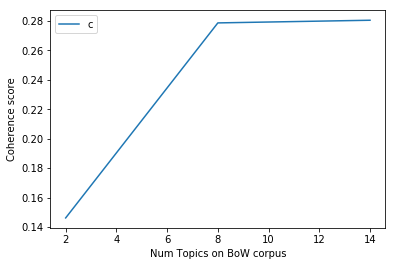

In [36]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics on BoW corpus")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## with TF-IDF

In [37]:
model_list_2, coherence_values_2 = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=clean, start=2, limit=20, step=6)

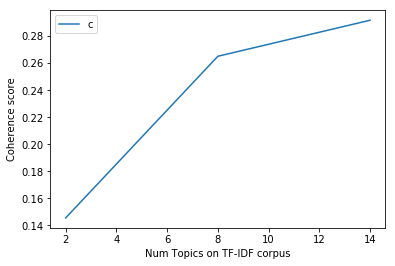

In [38]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_2)
plt.xlabel("Num Topics on TF-IDF corpus")
plt.ylabel("Coherence score")
plt.legend(("coherence_values_2"), loc='best')
plt.show()

## Visualization

### BoW model Visualization

In [39]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.000358  0.018660       1        1  14.552437
4     -0.050891 -0.004931       2        1  14.373687
5     -0.084254  0.048575       3        1  13.303196
2     -0.097092 -0.033091       4        1  12.722906
0      0.029448 -0.145518       5        1  11.960859
1     -0.027042  0.095637       6        1  11.393596
6      0.073096 -0.050716       7        1  11.095523
7      0.157093  0.071384       8        1  10.597790, topic_info=     Category         Freq        Term        Total  loglift  logprob
118   Default  1952.000000       suara  1952.000000  30.0000  30.0000
15    Default  1263.000000       salah  1263.000000  29.0000  29.0000
1765  Default   432.000000        misi   432.000000  28.0000  28.0000
1766  Default   436.000000        visi   436.000000  27.0000  27.0000
1287  Default   886.000000       debat   886.000000  26.0000  26.0000
845   Default   588.000000       surat   588.000000  25.0000  25.0000
69    Default  1941.000000       jujur  1941.000000  24.0000  24.0000
281   Default   566.000000       allah   566.000000  23.0000  23.0000
108   Default   681.000000          uu   681.000000  22.0000  22.0000
465   Default   591.000000      capres   591.000000  21.0000  21.0000
66    Default  1968.000000        adil  1968.000000  20.0000  20.0000
394   Default   544.000000       april   544.000000  19.0000  19.0000
306   Default   759.000000         tps   759.000000  18.0000  18.0000
57    Default  2859.000000      rakyat  2859.000000  17.0000  17.0000
31    Default  2544.000000      curang  2544.000000  16.0000  16.0000
975   Default   444.000000       kotak   444.000000  15.0000  15.0000
112   Default  2235.000000  selenggara  2235.000000  14.0000  14.0000
2     Default   470.000000      rentak   470.000000  13.0000  13.0000
0     Default   487.000000       kalah   487.000000  12.0000  12.0000
85    Default   495.000000       input   495.000000  11.0000  11.0000
1289  Default   343.000000         ktp   343.000000  10.0000  10.0000
99    Default   563.000000     sejarah   563.000000   9.0000   9.0000
150   Default   334.000000        kota   334.000000   8.0000   8.0000
313   Default   516.000000        kpps   516.000000   7.0000   7.0000
369   Default   727.000000   demokrasi   727.000000   6.0000   6.0000
838   Default   216.000000    cawapres   216.000000   5.0000   5.0000
1414  Default   177.000000        rabu   177.000000   4.0000   4.0000
192   Default  1050.000000      negara  1050.000000   3.0000   3.0000
1406  Default   468.000000      daftar   468.000000   2.0000   2.0000
81    Default  1659.000000       pilih  1659.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
307    Topic8    82.067024         wib   128.979004   1.7924  -5.4016
150    Topic8   193.595184        kota   334.389282   1.6980  -4.5434
734    Topic8   188.728561     jakarta   329.058167   1.6886  -4.5688
382    Topic8    96.641533       rapat   159.052277   1.7463  -5.2381
273    Topic8   226.313873    terburuk   413.502045   1.6418  -4.3872
475    Topic8   157.943558     tanggal   280.473236   1.6703  -4.7469
313    Topic8   263.747894        kpps   516.056519   1.5733  -4.2341
16     Topic8   214.719330     tinggal   435.819824   1.5366  -4.4398
750    Topic8    87.061035       camat   154.971405   1.6679  -5.3425
99     Topic8   257.159546     sejarah   563.298340   1.4604  -4.2594
142    Topic8   276.165588       tugas   667.229980   1.3624  -4.1881
848    Topic8    63.185474         pps   106.899414   1.7187  -5.6631
592    Topic8   199.378357          ri   499.437347   1.3262  -4.5139
10     Topic8   215.953537     laksana   654.882446   1.1351  -4.4341
114    Topic8   135.226196     anggota   362.744080   1.2578  -4.9022
1827   Topic8    48.405930       lpsdk    79.592545   1.7472  -5.9295
81     Topic8   295.040985       pilih  1659.733887   0.5

### TF-IDF model Visualization

In [40]:
# Based on https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [41]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.021687  0.012766       1        1  13.936916
4     -0.026412 -0.055840       2        1  12.719642
6     -0.054871  0.061373       3        1  12.640291
5      0.030316  0.026654       4        1  12.639302
2     -0.044556 -0.032510       5        1  12.258498
7     -0.016409  0.010912       6        1  12.199610
3      0.027780 -0.028750       7        1  12.084602
0      0.062465  0.005395       8        1  11.521140, topic_info=     Category        Freq        Term       Total  loglift  logprob
99    Default  166.000000     sejarah  166.000000  30.0000  30.0000
1765  Default  133.000000        misi  133.000000  29.0000  29.0000
1766  Default  129.000000        visi  129.000000  28.0000  28.0000
273   Default  144.000000    terburuk  144.000000  27.0000  27.0000
108   Default  177.000000          uu  177.000000  26.0000  26.0000
189   Default   67.000000       pasal   67.000000  25.0000  25.0000
394   Default  121.000000       april  121.000000  24.0000  24.0000
898   Default   35.000000        lucu   35.000000  23.0000  23.0000
120   Default  190.000000    presiden  190.000000  22.0000  22.0000
281   Default  135.000000       allah  135.000000  21.0000  21.0000
275   Default   81.000000        bang   81.000000  20.0000  20.0000
419   Default   97.000000         min   97.000000  19.0000  19.0000
199   Default   77.000000   amburadul   77.000000  18.0000  18.0000
1250  Default   31.000000   sukseskan   31.000000  17.0000  17.0000
350   Default   91.000000      undang   91.000000  16.0000  16.0000
237   Default   68.000000      partai   68.000000  15.0000  15.0000
1350  Default   27.000000       repot   27.000000  14.0000  14.0000
11    Default  116.000000     langgar  116.000000  13.0000  13.0000
96    Default  117.000000       pakai  117.000000  12.0000  12.0000
233   Default  102.000000       calon  102.000000  11.0000  11.0000
21    Default  119.000000       ulang  119.000000  10.0000  10.0000
766   Default   62.000000        palu   62.000000   9.0000   9.0000
688   Default   38.000000      bobrok   38.000000   8.0000   8.0000
185   Default   85.000000        urus   85.000000   7.0000   7.0000
1811  Default   29.000000      boikot   29.000000   6.0000   6.0000
1648  Default   30.000000        ayat   30.000000   5.0000   5.0000
1807  Default   17.000000     skeptis   17.000000   4.0000   4.0000
1731  Default   25.000000    batalkan   25.000000   3.0000   3.0000
781   Default   51.000000        azab   51.000000   2.0000   2.0000
235   Default   77.000000    kampanye   77.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
1158   Topic8   12.558345       jamin   28.413277   1.3445  -6.1059
621    Topic8   14.768625      gimana   35.777878   1.2762  -5.9438
614    Topic8   12.769087       tuduh   29.743433   1.3154  -6.0892
1765   Topic8   35.075668        misi  133.705719   0.8229  -5.0788
1766   Topic8   33.794987        visi  129.242783   0.8196  -5.1160
108    Topic8   39.253525          uu  177.685944   0.6510  -4.9662
194    Topic8   17.198370      pidana   50.238327   1.0890  -5.7915
892    Topic8   28.538513    langsung  127.359192   0.6652  -5.2850
66     Topic8   47.592228        adil  326.771057   0.2344  -4.7736
69     Topic8   44.961636       jujur  312.486572   0.2222  -4.8305
11     Topic8   26.327019     langgar  116.242241   0.6759  -5.3657
23     Topic8   56.171524         kpu  511.470398  -0.0479  -4.6079
236    Topic8   19.520336       lapor   67.606689   0.9187  -5.6648
1065   Topic8   22.725994     mending   98.186523   0.6976  -5.5128
72     Topic8   33.680862        kali  255.603622   0.1343  -5.1193
57     Topic8   40.424904      rakyat  411.277435  -0.1588  -4.9368
100    Topic8   20.348406         ayo   85.429680   0.7263  -5.6233
369    Topic8   26.448769   demokrasi  173.710632   0.2788  -5.3611
118    Topic8   3

## Classify Document to Topic

In [42]:
sample_index = randint(0,10000)
bow_corpus_sample(bow_corpus, sample_index)

Corpus sample index :  483
Word 19 ("menang") appears 1 time.
Word 31 ("curang") appears 3 time.
Word 62 ("bukti") appears 2 time.
Word 118 ("suara") appears 1 time.
Word 183 ("diam") appears 1 time.
Word 296 ("perang") appears 1 time.
Word 305 ("total") appears 1 time.
Word 720 ("sampah") appears 1 time.
Word 845 ("surat") appears 1 time.
Word 1084 ("kirim") appears 1 time.
Word 1085 ("malaysia") appears 1 time.
Word 1086 ("pra") appears 1 time.


In [43]:
for index, score in sorted(lda_model[bow_corpus[sample_index]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7461749911308289	 
Topic: 0.038*"curang" + 0.028*"debat" + 0.022*"kpu" + 0.019*"capres" + 0.014*"kalah" + 0.013*"selenggara" + 0.013*"presiden" + 0.011*"hoax" + 0.009*"cawapres" + 0.009*"menang"

Score: 0.2068978250026703	 
Topic: 0.054*"suara" + 0.036*"kpu" + 0.022*"surat" + 0.022*"uu" + 0.021*"misi" + 0.021*"visi" + 0.020*"rakyat" + 0.015*"kotak" + 0.015*"hasil" + 0.011*"pilih"


In [44]:
sorted_probability = sorted(lda_model.get_document_topics(bow_corpus[sample_index]), key = lambda x: x[1], reverse=True)

In [45]:
sorted_probability[0][0]

2

In [46]:
topic_list = []
for i in range(len(bow_corpus)):
    sorted_probability = sorted(lda_model.get_document_topics(bow_corpus[i]), key = lambda x: x[1], reverse=True)
    topic_list.append(sorted_probability[0][0])

In [47]:
df['topic'] = topic_list

In [55]:
df.head(10)

,text,username,modularity,clean,topic
0,Mereka itu korban yg kalah di 2014. Inget siap...,b12_7hon,3,"[korban, kalah, loloskan, pemilu, rentak]",7
1,Penomena @KPU_RI @KPU_ID tdk kuat scra lembaga...,harun_nugraha,15,"[fenomena, kuat, lembaga, laksana, baca, dr, m...",0
2,ngapain pemilu ulang broo klu kita 02 sdh mena...,totonaser11,19,"[pemilu, ulang, broo, menang, spy, jokowi, sid...",5
3,"Kl menerapkan ISO pasti kelar 1 minggu, ngga a...",rohmatjabbar,19,"[terap, selesai, minggu, korban, romusha, rodi...",0
4,Hayooo @KPU_ID @bawaslu_RI simak baik2 orasi k...,use_will,14,"[hayooo, simak, orasi, ketua, satgas, anti, cu...",5
5,Hampir semua daerah ricuh kok dibilang pemilu ...,triyantotoni,14,"[daerah, ricuh, dibilang, pemilu, lancar, aman...",1
6,Ga habis pikir sm @KPU_ID pasang badan habis2a...,misstince1,14,"[habis, pikir, pasang, badan, habis, an, pemilu]",4
7,@jokowi @mas_abudiman @bagja98 @kabarafif @Div...,hendry_much,17,"[hormat, bangsa, indonesia, sih, pecah, belah,...",5
8,@AgusYudhoyono @SBYudhoyono @AndiArief__ @PDem...,reno_2,21,"[kah, maksud, pemilu, jalan, lancar]",3
9,Anda punya bukti Jokowi curangi hasil Pemilu? ...,alalusebo,2,"[bukti, jokowi, curangi, hasil, pemilu, nuduh]",2


In [54]:
# Export to csv
df.to_csv('tweet_modularity_topic.csv', index=False)